API

In [1]:
# """
# Crypto Data Quality Project – Yearly OHLCV (Top-100 coins)
# Exactly matches PDF columns: symbol, date, open, high, low, close, volume
# No API key required – uses free tier with polite throttling
# """

from pycoingecko import CoinGeckoAPI
import pandas as pd
from datetime import datetime
import time
import os

# # --------------------------- CONFIG --------------------------- #
# cg = CoinGeckoAPI()                              # free tier
# VS_CURR = 'usd'
# DAYS = 365                                       # full year
# PER_PAGE = 100
# OUTPUT_PATH = r"C:\Users\w\Downloads\top100_ohlcv_yearly.csv"
# # -------------------------------------------------------------- #


# def get_top100() -> list[dict]:
#     """Return list of {'id': <coin_id>, 'symbol': <SYMBOL>} for top-100 by market-cap."""
#     markets = cg.get_coins_markets(
#         vs_currency=VS_CURR,
#         order='market_cap_desc',
#         per_page=PER_PAGE,
#         page=1
#     )
#     return [{'id': c['id'], 'symbol': c['symbol'].upper()} for c in markets]


# def fetch_ohlcv(coin_id: str, symbol: str) -> pd.DataFrame:
#     """
#     Fetch daily OHLCV for a single coin.
#     Returns DataFrame with columns: symbol, date, open, high, low, close, volume
#     """
#     # OHLC candles
#     ohlc = cg.get_coin_ohlc_by_id(id=coin_id, vs_currency=VS_CURR, days=DAYS)
#     df = pd.DataFrame(ohlc, columns=['timestamp', 'open', 'high', 'low', 'close'])

#     # Daily volume
#     vol_data = cg.get_coin_market_chart_by_id(
#         id=coin_id, vs_currency=VS_CURR, days=DAYS, interval='daily'
#     )
#     vol_df = pd.DataFrame(vol_data['total_volumes'], columns=['timestamp', 'volume'])

#     # Merge & format
#     df = df.merge(vol_df, on='timestamp', how='left')
#     df['symbol'] = symbol
#     df['date'] = pd.to_datetime(df['timestamp'], unit='ms').dt.date
#     df = df[['symbol', 'date', 'open', 'high', 'low', 'close', 'volume']]
#     return df


# def main():
#     coins = get_top100()
#     if not coins:
#         print("No coins retrieved – aborting.")
#         return

#     frames = []
#     for idx, c in enumerate(coins, 1):
#         print(f"[{idx:03d}/100] {c['symbol']}")
#         try:
#             frames.append(fetch_ohlcv(c['id'], c['symbol']))
#         except Exception as e:
#             print(f"  ⚠️  skipped {c['symbol']}: {e}")
#         time.sleep(1.2)          # respect free-tier rate limit

#     final = pd.concat(frames, ignore_index=True)
#     os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)
#     final.to_csv(OUTPUT_PATH, index=False)
#     print(f"✅ Saved {len(final)} rows -> {OUTPUT_PATH}")


# if __name__ == '__main__':
#     main()

IMPORT LIBRARIES

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itables

Load and parse dataset


In [3]:
df = pd.read_csv(r"C:\Users\w\Downloads\top100_ohlcv_yearly.csv", parse_dates=['date'])
itables.show(df)

Loading ITables v2.5.2 from the internet... (need help?)


Sorting & cleaning & validation

In [4]:
df = df.sort_values(['symbol','date']).reset_index(drop=True)

df['symbol'] = df['symbol'].str.upper().str.strip()
df = df.drop_duplicates(subset=['symbol','date'])

#assert df[['open','high','low','close','volume']].notna().all().all(), "Missing values!"
assert (df['high'] >= df['low']).all(), "High < Low!"
assert (df['close'].between(df['low'], df['high'])).all(), "Close outside Low-High!"
#assert (df['volume'] > 0).all(), "Negative volume!"

print(df[['open','high','low','close','volume']].isna().sum())

open       0
high       0
low        0
close      0
volume    10
dtype: int64


Helper columns for analysis

In [5]:
# Daily returns
df['ret'] = df.groupby('symbol')['close'].pct_change()

# 30-day rolling volatility of returns
df['volatility_30'] = df.groupby('symbol')['ret'].transform(lambda x: x.rolling(30).std())

# 30-day average trading volume
df['volume_avg30'] = df.groupby('symbol')['volume'].transform(lambda x: x.rolling(30).mean())

# Volume spike indicator (current volume vs 30-day average)
df['vol_spike'] = df['volume'] / df['volume_avg30']

#  Drawdown calculation
g = df.groupby('symbol')
df['running_max'] = g['close'].cummax()
df['drawdown'] = (df['close'] - df['running_max']) / df['running_max']


itables.show(df)

Loading ITables v2.5.2 from the internet... (need help?)


Save cleaned dataset

In [6]:
df.to_csv(r"C:\Users\w\Downloads\top100_ohlcv_yearly_clean.csv", index=False)

Q1 : Highest volatility last year


Highest Average 30-Day Volatility (Year)
symbol
M        0.307545
PUMP     0.172363
WLD      0.142061
PI       0.137980
ENA      0.135820
OKB      0.128717
ZEC      0.127430
PEPE     0.118241
ARB      0.112660
TRUMP    0.110582
Name: volatility_30, dtype: float64


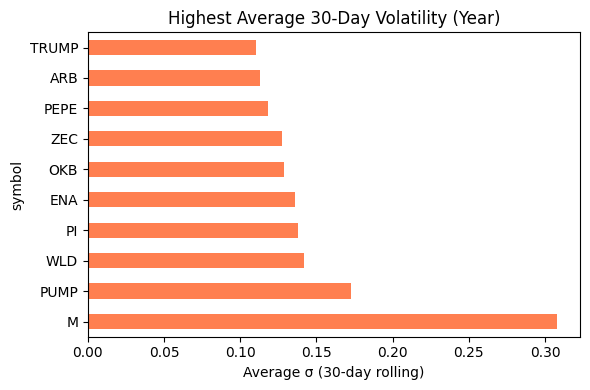

In [ ]:
ؤ

print("Highest Average 30-Day Volatility (Year)")
print(top_vol)

plt.figure(figsize=(6, 4))
top_vol.plot(kind='barh', color='coral')
plt.title('Highest Average 30-Day Volatility (Year)')
plt.xlabel('Average σ (30-day rolling)')
plt.tight_layout()
plt.show()

Q2 : Which coins saw the strongest growth trend last year

Strongest Growth Trend (Year)
symbol
M       12.620789
ZEC      7.758417
HYPE     3.122183
RAIN     1.745666
XMR      1.567137
WBT      1.547599
BGB      1.226994
OKB      1.085613
PAXG     0.577403
XAUT     0.570783
Name: ret, dtype: float64


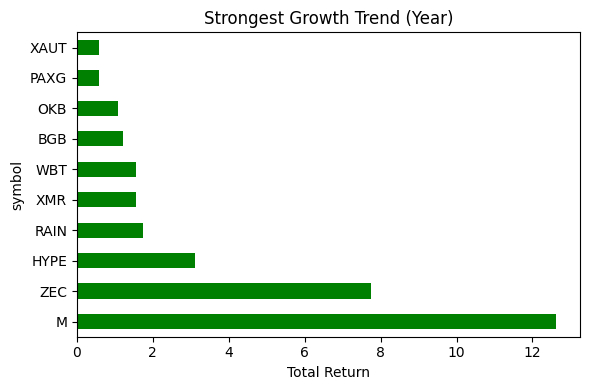

In [8]:

# =========================
# Strongest growth trend (Year)
# =========================

top_growth = (
    df.groupby('symbol')['ret']
      .apply(lambda x: (1 + x.fillna(0)).prod() - 1)   # total return per symbol
      .sort_values(ascending=False)
      .head(10)
)

print("Strongest Growth Trend (Year)")
print(top_growth)

plt.figure(figsize=(6, 4))
top_growth.plot(kind='barh', color='green')
plt.title('Strongest Growth Trend (Year)')
plt.xlabel('Total Return')
plt.tight_layout()
plt.show()

Q3 : Which coins are the most stable (lowest volatility) last year?

Most Stable Coins (Lowest Volatility)
symbol
BUIDL    0.000000
USDC     0.000090
USDG     0.000408
DAI      0.000468
USDT     0.000489
PYUSD    0.000505
USDTB    0.000540
USDS     0.000831
USDE     0.000867
RLUSD    0.000905
Name: volatility_30, dtype: float64


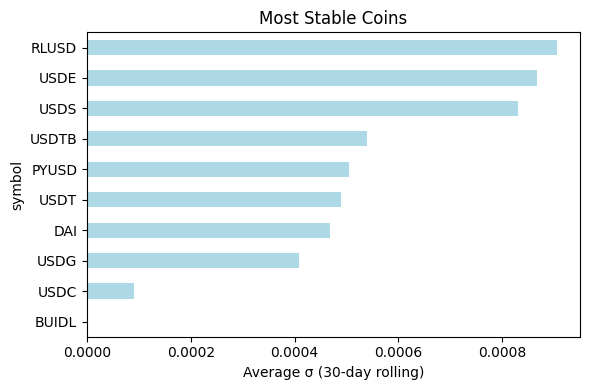

In [9]:
# === Most stable coins (lowest 30-day volatility) ===
low_vol = df.groupby('symbol')['volatility_30'].mean().nsmallest(10)

print("Most Stable Coins (Lowest Volatility)")
print(low_vol)

plt.figure(figsize=(6, 4))
low_vol.plot(kind='barh', color='lightblue')
plt.title('Most Stable Coins')
plt.xlabel('Average σ (30-day rolling)')
plt.tight_layout()
plt.show()

Q4 : Which coins had abnormal volume spikes (possible manipulation) last year?

Coins with Most Abnormal Volume Spikes (>3× 30-day avg)
       symbol  spike_days
67       XAUT          15
26        KCS          12
43      SUSDS          11
70        ZEC          10
57      USDTB           9
9     BSC-USD           9
53       USDG           9
44  SYRUPUSDC           8
42      SUSDE           7
30        OKB           7


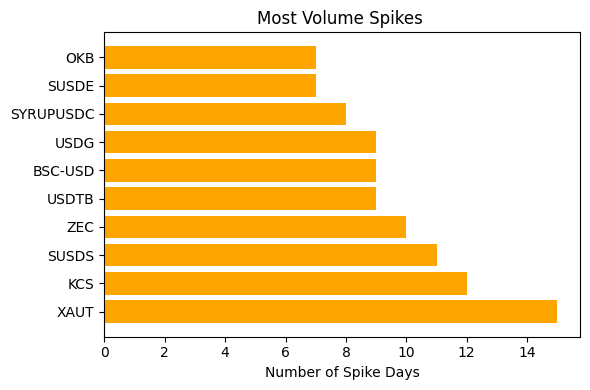

In [10]:
spikes = (
    df[df['vol_spike'] > 3]
    .groupby('symbol')
    .size()
    .reset_index(name='spike_days')   # convert to DataFrame
    .sort_values('spike_days', ascending=False)
    .head(10)
)

print("Coins with Most Abnormal Volume Spikes (>3× 30-day avg)")
print(spikes)

plt.figure(figsize=(6, 4))
plt.barh(spikes['symbol'], spikes['spike_days'], color='orange')
plt.title('Most Volume Spikes ')
plt.xlabel('Number of Spike Days')
plt.tight_layout()
plt.show()

Q5 : Which coins saw the largest drop from peak to bottom last year?

Largest Drop from Peak to Bottom (Max Draw-down)
symbol
PI      -0.907726
TRUMP   -0.871097
APT     -0.846259
WLD     -0.845004
ARB     -0.829764
PEPE    -0.823504
FIL     -0.822441
POL     -0.812649
ICP     -0.811234
VET     -0.807543
Name: drawdown, dtype: float64


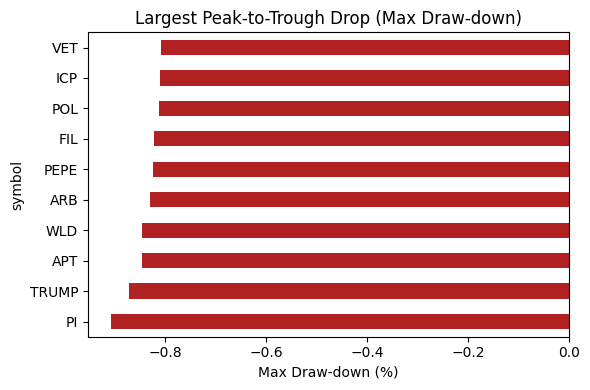

In [11]:
# === Largest draw-down (peak-to-trough) ===
max_drop = df.groupby('symbol')['drawdown'].min().sort_values().head(10)   

print("Largest Drop from Peak to Bottom (Max Draw-down)")
print(max_drop)

plt.figure(figsize=(6, 4))
max_drop.plot(kind='barh', color='firebrick')
plt.title('Largest Peak-to-Trough Drop (Max Draw-down)')
plt.xlabel('Max Draw-down (%)')
plt.tight_layout()
plt.show()

Q6 : Which coins had the highest liquidity based on volume last year?

Highest Liquidity (Average Daily Volume)
symbol
USDT       7.984929e+10
BTC        4.904580e+10
ETH        2.945257e+10
USDC       1.047373e+10
SOL        6.773493e+09
XRP        6.492141e+09
DOGE       3.159647e+09
BSC-USD    1.756599e+09
BNB        1.605080e+09
PEPE       1.386883e+09
Name: volume, dtype: float64


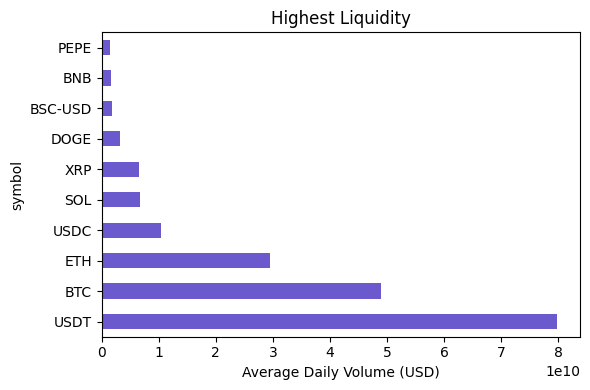

In [12]:
# === Highest liquidity (average daily volume) ===
avg_vol = df.groupby('symbol')['volume'].mean().sort_values(ascending=False).head(10)

print("Highest Liquidity (Average Daily Volume)")
print(avg_vol)

plt.figure(figsize=(6, 4))
avg_vol.plot(kind='barh', color='slateblue')
plt.title('Highest Liquidity')
plt.xlabel('Average Daily Volume (USD)')
plt.tight_layout()
plt.show()

Q7 : Which coins showed the strongest recovery after a 20 % drop last year?


C:\Users\w\AppData\Local\Temp\ipykernel_18624\3861577477.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(recovery_days)


Strongest Recovery After 20 % Drop (days)
symbol
CRO            4
OKB            4
M              4
ZEC            4
PUMP           8
SOL            8
BNSOL          8
FIGR_HELOC    12
WBT           12
XRP           12
dtype: int64


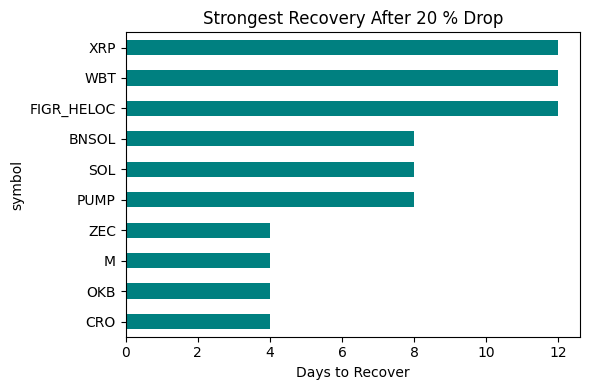

In [13]:
def recovery_days(g):
    # Work with positional iloc-based slices to avoid label/position confusion
    closes = g['close'].reset_index(drop=True)
    dates = g['date'].reset_index(drop=True)
    peak = closes.cummax()
    drop = (closes - peak) / peak

    recovery_list = []
    for j in range(len(g)):
        if drop.iloc[j] <= -0.20:  # 20% drop
            target = peak.iloc[j]
            after_hits = closes.iloc[j:].ge(target).values
            if after_hits.any():
                offset = int(np.argmax(after_hits))  # first hit position offset
                days = (dates.iloc[j + offset] - dates.iloc[j]).days
                recovery_list.append(days)

    # return NaN when no recovery found so pandas.dropna() will remove it
    return np.nan if not recovery_list else int(min(recovery_list))

recovery = (
    df.groupby('symbol')
      .apply(recovery_days)
)

# The above apply returns a Series indexed by symbol. Clean and sort.
recovery = recovery.dropna().astype(int).sort_values().head(10)

print("Strongest Recovery After 20 % Drop (days)")
print(recovery)

plt.figure(figsize=(6, 4))
recovery.plot(kind='barh', color='teal')
plt.title('Strongest Recovery After 20 % Drop')
plt.xlabel('Days to Recover')
plt.tight_layout()
plt.show()

Q8 : Which coins had the cleanest trend (lowest number of direction changes) last year?

C:\Users\w\AppData\Local\Temp\ipykernel_18624\3570200189.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_ret = df.set_index('date').groupby('symbol')['ret'].resample('M').apply(lambda x: (1 + x).prod() - 1)


Cleanest Trend (Fewest Direction Changes)
symbol
BUIDL         1
CC            1
SUSDS         1
FIGR_HELOC    2
M             2
BFUSD         3
KHYPE         3
ASTER         3
RAIN          3
PUMP          3
Name: ret, dtype: int64


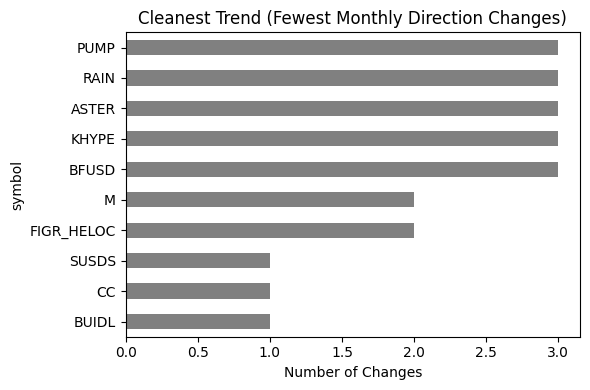

In [14]:
monthly_ret = df.set_index('date').groupby('symbol')['ret'].resample('M').apply(lambda x: (1 + x).prod() - 1)
direction  = monthly_ret.groupby('symbol').apply(lambda x: (x > 0).astype(int).diff().ne(0).sum())
clean_trend = direction.sort_values().head(10)

print("Cleanest Trend (Fewest Direction Changes)")
print(clean_trend)

plt.figure(figsize=(6, 4))
clean_trend.plot(kind='barh', color='grey')
plt.title('Cleanest Trend (Fewest Monthly Direction Changes)')
plt.xlabel('Number of Changes')
plt.tight_layout()
plt.show()

Q9 : Which coins showed the strongest bounce after touching their 52-week low?

Strongest Bounce After 52-Week Low (30-day return)
symbol
M         2432.615404
MNT        282.594580
BGB        195.705521
RETH       182.596340
RSETH      181.622781
WSTETH     181.465297
WBETH      181.451275
WEETH      181.283644
ETH        179.797029
WETH       179.457780
Name: post_low, dtype: float64


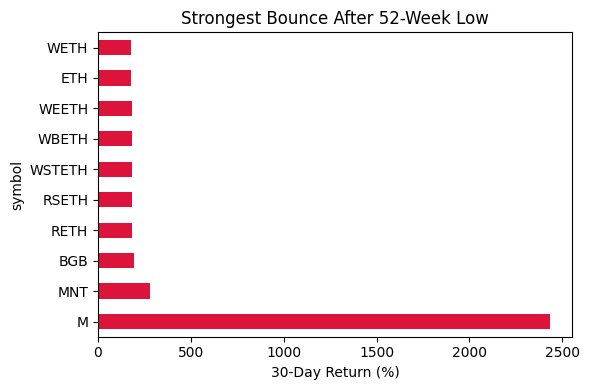

In [ ]:
df = df.sort_values(['symbol','date'])
g  = df.groupby('symbol', group_keys=False)

df['52w_low']  = g['close'].transform(lambda s: s.rolling(window=365,min_periods=1).min())
df['post_low'] = g['close'].transform(lambda s: (s.shift(-30)/s-1)*100)

mask = (df['close']==df['52w_low']) & df['post_low'].notna() & (df['post_low']>0)

bounce = (df.loc[mask]
            .groupby('symbol')['post_low']
            .max()
            .sort_values(ascending=False)
            .head(10))

print("Strongest Bounce After 52-Week Low (30-day return)")
print(bounce)

plt.figure(figsize=(6,4))
bounce.plot(kind='barh',color='crimson')
plt.title('Strongest Bounce After 52-Week Low')
plt.xlabel('30-Day Return (%)')
plt.tight_layout()
plt.show()

Q10 : Which coins had unusual price gaps (bad data or market anomaly)?

In [36]:
# (pandas and matplotlib are already imported in an earlier cell)
df['gap'] = ~df['close'].between(df['low'], df['high'])
gaps = df[df['gap']].groupby('symbol').size().sort_values(ascending=False).head(10)

print("Unusual Price Gaps (close outside daily high-low)")
if gaps.empty:
	print("No unusual price gaps found.")
else:
	print(gaps)
	plt.figure(figsize=(6, 4))
	gaps.plot(kind='barh', color='grey')
	plt.title('Unusual Price Gaps (close outside high-low)')
	plt.xlabel('Number of Gap Days')
	plt.tight_layout()
	plt.show()

Unusual Price Gaps (close outside daily high-low)
No unusual price gaps found.


save cleaned dataset

In [17]:

df.to_csv(r"C:\Users\w\Downloads\top100_crypto_yearly_clean.csv", index=False)
print("Clean dataset saved → top100_crypto_yearly_clean.csv")

Clean dataset saved → top100_crypto_yearly_clean.csv


In [28]:
df2 = pd.read_csv(r"crypto_ohlcv_with_cap.csv", parse_dates=['date'])

In [29]:
itables.show(df2)

Loading ITables v2.5.2 from the internet... (need help?)


Q11 : Top 10 coins by Market-Cap

symbol
BTC      1.821779e+12
ETH      3.640395e+11
USDT     1.845642e+11
XRP      1.327899e+11
BNB      1.233271e+11
SOL      7.877762e+10
USDC     7.602454e+10
TRX      2.653367e+10
STETH    2.601145e+10
DOGE     2.320320e+10
Name: market_cap, dtype: float64


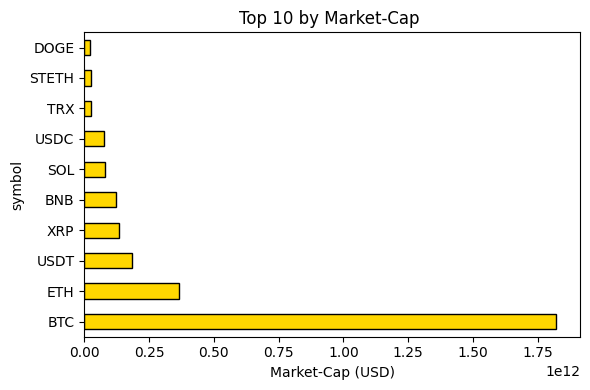

In [40]:
top10_mc = df2.groupby('symbol')['market_cap'].last().sort_values(ascending=False).head(10)

print(top10_mc)


plt.figure(figsize=(6, 4))
top10_mc.plot(kind='barh', color='gold', edgecolor='black')
plt.title('Top 10 by Market-Cap ')
plt.xlabel('Market-Cap (USD)')
plt.tight_layout()
plt.show()

 Q12 : Largest Market-Cap Decline

symbol
TRUMP   -0.853845
PEPE    -0.762657
APT     -0.757313
TON     -0.752149
NEAR    -0.715596
DOT     -0.707633
POL     -0.681062
ARB     -0.668816
FIL     -0.667549
SHIB    -0.656361
Name: market_cap, dtype: float64


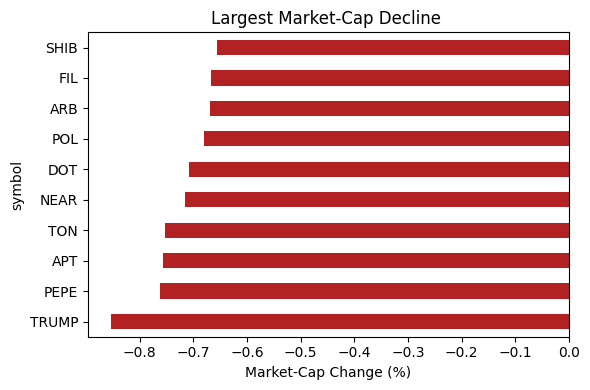

In [39]:
mc_decline = ((df2.groupby('symbol')['market_cap'].last() -
               df2.groupby('symbol')['market_cap'].first()) /
              df2.groupby('symbol')['market_cap'].first()).sort_values().head(10)

print(mc_decline)


plt.figure(figsize=(6, 4))
mc_decline.plot(kind='barh', color='firebrick')
plt.title('Largest Market-Cap Decline ')
plt.xlabel('Market-Cap Change (%)')
plt.tight_layout()
plt.show()